# Explore here

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import joblib

## Paso 1: Carga del conjunto de datos

In [43]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(url)

## Paso 2: Realiza un EDA completo

In [44]:
# Ver la base de datos
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [45]:
df.shape

(1338, 7)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [47]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [48]:
# Comprobar si hay valores nulos
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [49]:
# Comprobar duplicados
df.duplicated().sum()

np.int64(1)

In [50]:
# Eliminar duplicados
df = df.drop_duplicates()

In [51]:
# Revisar valores unicos
for col in ['sex', 'smoker', 'region']:
    print(f'\nValores únicos en "{col}":')
    print(df[col].value_counts(dropna=False))


Valores únicos en "sex":
sex
male      675
female    662
Name: count, dtype: int64

Valores únicos en "smoker":
smoker
no     1063
yes     274
Name: count, dtype: int64

Valores únicos en "region":
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


### Análisis univariado

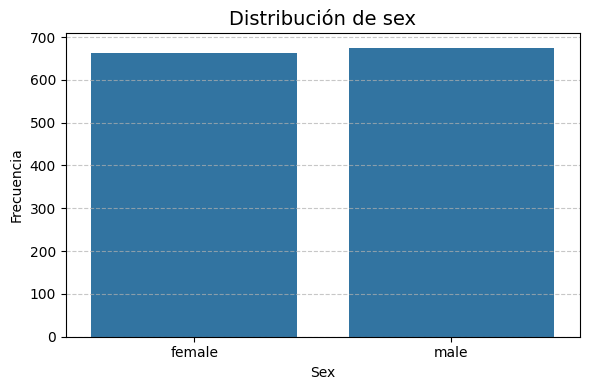

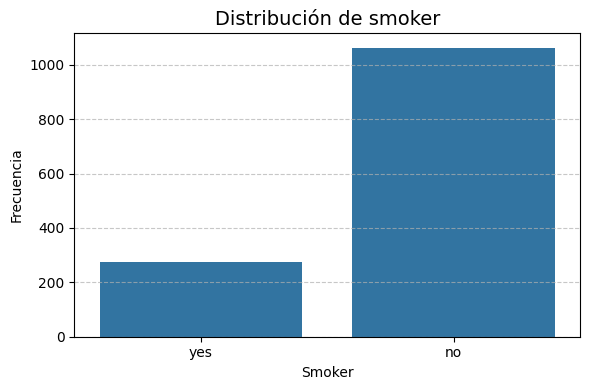

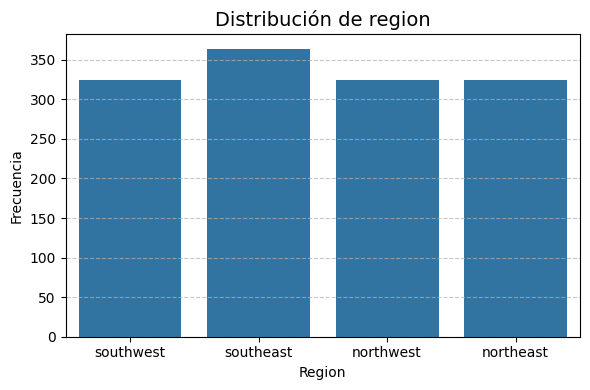

In [52]:
# Ver la distribución de frecuencias de las variables categóricas
# Lista de columnas categóricas
cat_cols = ['sex', 'smoker', 'region']

# Gráficos de barras
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribución de {col}', fontsize=14)
    plt.xlabel(col.capitalize())
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Resumen del análisis de variables categóricas
- sex: distribución bastante equilibrada entre hombres y mujeres.
- smoker: hay un claro desbalance. Es esperable (hay más no fumadores), pero podría influir en el modelo.
- region: distribución razonablemente uniforme.

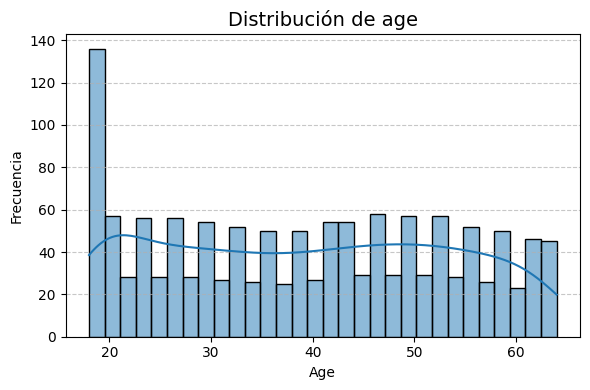

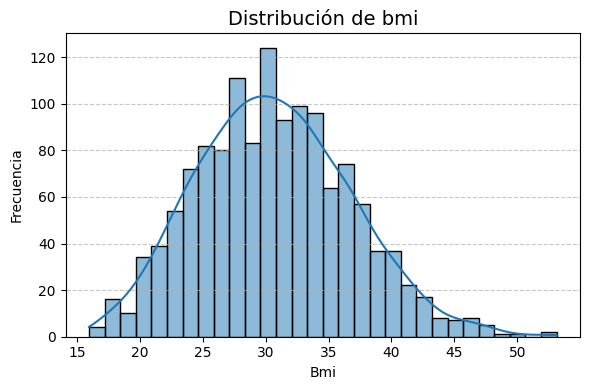

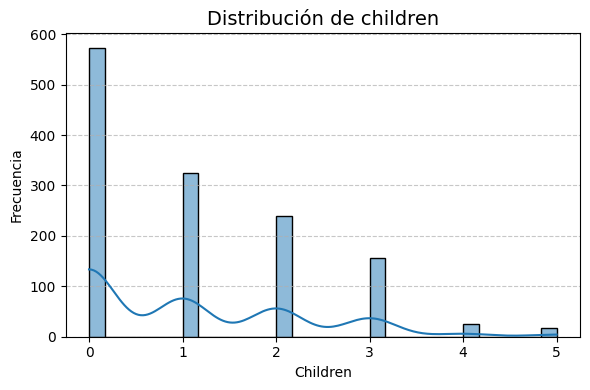

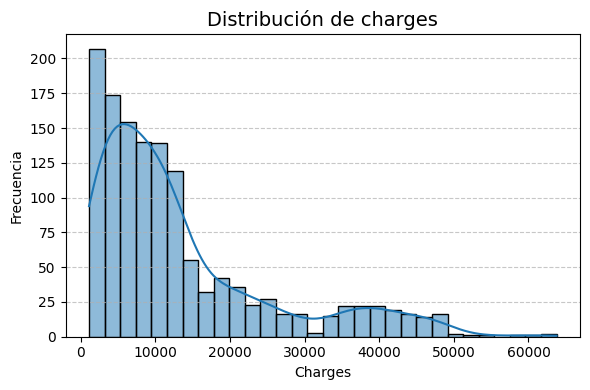

In [53]:
# Ver la distribución de frecuencias de las variables categóricas
# Lista de columnas numéricas
num_cols = ['age', 'bmi', 'children', 'charges']

# Histograma por variable
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}', fontsize=14)
    plt.xlabel(col.capitalize())
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Resumen del análisis de las variables numéricas
- age: pico inicial en menores de 20 años (frecuencia ≈130).Resto de edades distribuidas de forma razonablemente uniforme entre los 20 y los 60 años.
- bmi: valores más frecuentes entre 25 y 35, lo cual se considera peso normal a sobrepeso.Puede haber algunos outliers que conviene revisar después.
- children: mayoría de personas sin hijos (valor 0).
- charges: distribución altamente sesgada a la izquierda. Muchas personas con primas bajas y pocas personas con primas muy altas.

### Análisis bivariado

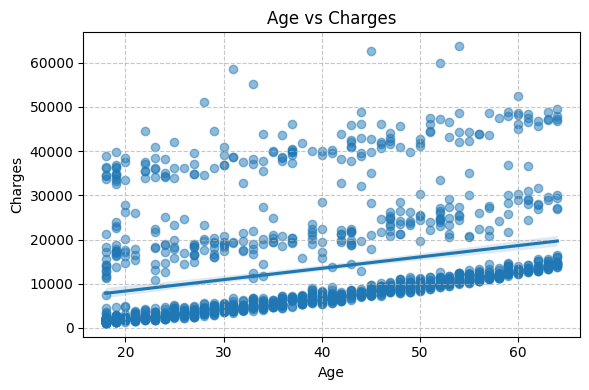

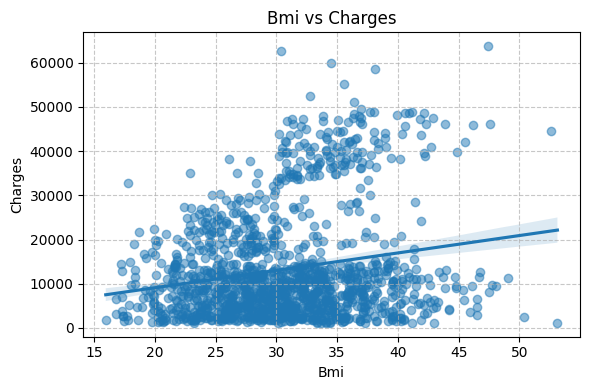

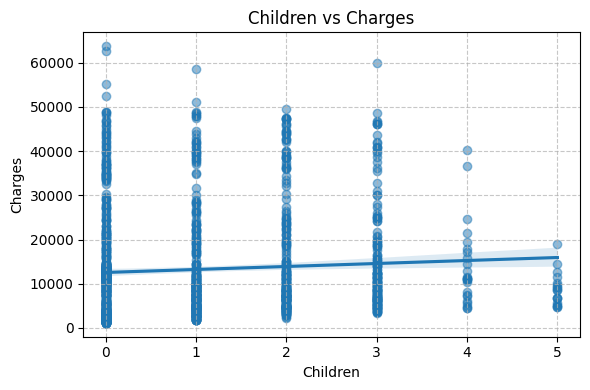

In [54]:
# Ver cómo se relaciona cada variable con charges
# Variables numéricas predictoras
num_cols = ['age', 'bmi', 'children']

# Gráficos de dispersión vs. charges
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=col, y='charges', data=df, scatter_kws={'alpha':0.5})
    plt.title(f'{col.capitalize()} vs Charges')
    plt.xlabel(col.capitalize())
    plt.ylabel('Charges')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Resumen de la análisis bivariado: variables numéricas vs. charges
- age vs. charges: relación positiva clara, a mayor edad, mayor prima médica. Hay algo de dispersión, pero la tendencia general es creciente (buena candidata para el modelo lineal).

- bmi vs. charges: relación débil y dispersa. Algunos valores de charges son muy altos incluso para IMC moderado, esto puede sugerir que otras variables (como smoker) podrían estar influyendo.

- children vs. charges: no parece haber una tendencia clara, sospecho que children no aporta mucho al modelo.

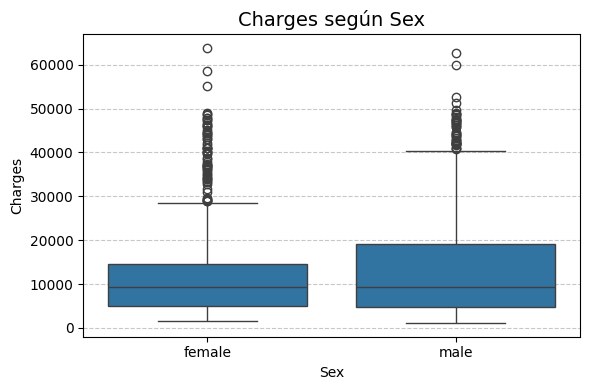

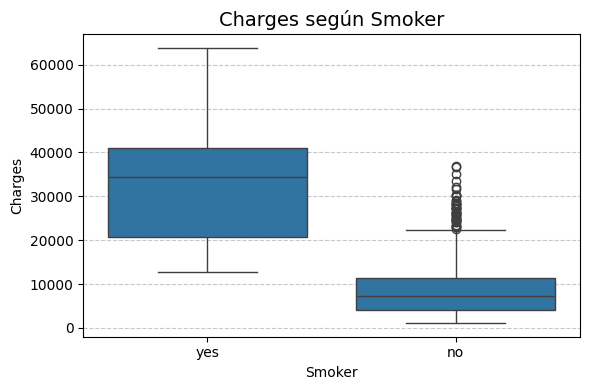

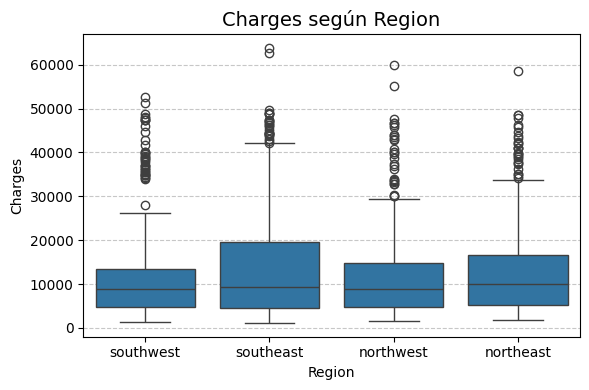

In [55]:
# Comparar las variables categóricas vs. charges usando boxplots
# Variables categóricas
cat_cols = ['sex', 'smoker', 'region']

# Boxplots de charges por categoría
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col, y='charges', data=df)
    plt.title(f'Charges según {col.capitalize()}', fontsize=14)
    plt.xlabel(col.capitalize())
    plt.ylabel('Charges')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Resumen de las análisis bivariado de las variables categóricas vs. charges
- sex vs charges: hay una pequeña diferencia, pero la mediana y el rango son similares entre male y female.

- smoker vs charges: impacto muy claro. Las primas de los fumadores (yes) son más altas que las de los no fumadores.

- region vs charges: No hay una mucha diferencia. La región parece tener poco impacto en el coste del seguro.

### Análisis de correlación

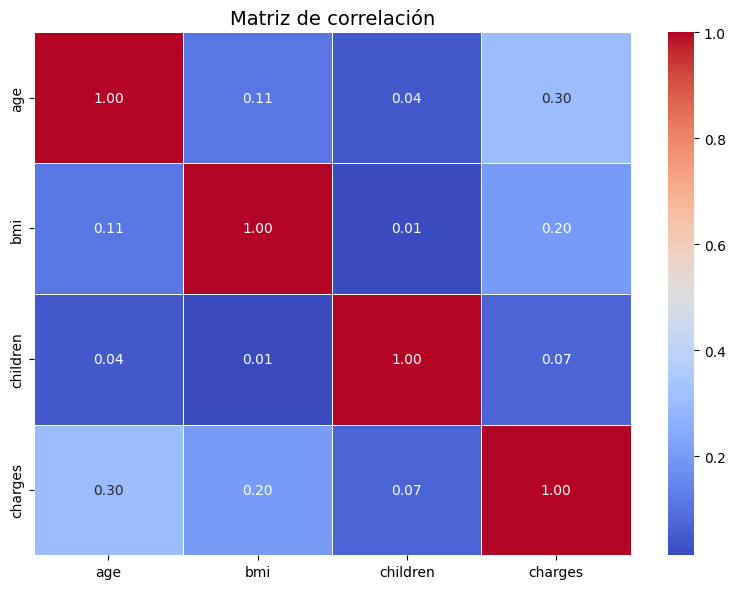

In [56]:
# Calcular matriz de correlación (solo numéricas)
correlation = df.corr(numeric_only=True)

# Mostrar heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación', fontsize=14)
plt.tight_layout()
plt.show()

### Conclusión del EDA
Con este análisis, hemos aprendido que:

- smoker es la variable más influyente (lo vimos en los boxplots).

- age es la variable numérica más correlacionada con charges.

- children no aporta mucho, pero podríamos incluirla inicialmente y luego evaluar.

### Codificación de variables categóricas

In [57]:
# Copiar el dataframe original para no modificarlo directamente
df_encoded = df.copy()

# Label Encoding para 'sex' y 'smoker'
df_encoded['sex'] = df_encoded['sex'].map({'male': 0, 'female': 1})
df_encoded['smoker'] = df_encoded['smoker'].map({'no': 0, 'yes': 1})

# One Hot Encoding para 'region'
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)

# Verificar resultado
df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,False,False,True
1,18,0,33.770,1,0,1725.55230,False,True,False
2,28,0,33.000,3,0,4449.46200,False,True,False
3,33,0,22.705,0,0,21984.47061,True,False,False
4,32,0,28.880,0,0,3866.85520,True,False,False


### División en conjuntos de entrenamiento y prueba

In [58]:
# Separar variables independientes (X) y la dependiente (y)
X = df_encoded.drop(columns='charges')
y = df_encoded['charges']

# División 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Paso 3: Construcción del modelo de regresión lineal (modelo base)

In [59]:
# Instanciar el modelo
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [60]:
# Evaluar el modelo
# Predecir con el conjunto de test
y_pred = model.predict(X_test)

# Evaluar
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MSE: 35478020.68
R²: 0.81


In [61]:
# calcular el RMSE (raíz del MSE)
rmse = np.sqrt(35478020.68)
print(rmse)

5956.342894763531


### Conclusión:
- El modelo base tiene buena capacidad predictiva (R² = 0.81).

- El error promedio absoluto es de casi 6000.

A mejorar: reducir el error.

### Paso 4: Optimiza el modelo anterior
Vamos a probar Ridge y Lasso

In [62]:
# Escalar las variables independientes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
# Instanciar modelos con valores iniciales de alpha
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)

# Entrenar
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

# Predecir
ridge_preds = ridge.predict(X_test_scaled)
lasso_preds = lasso.predict(X_test_scaled)

In [64]:
# Evaluar
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f" {name}")
    print(f"   MSE: {mse:.2f}")
    print(f"   R²: {r2:.2f}")
    print()

evaluate_model("Ridge", y_test, ridge_preds)
evaluate_model("Lasso", y_test, lasso_preds)

 Ridge
   MSE: 35512474.83
   R²: 0.81

 Lasso
   MSE: 35485364.96
   R²: 0.81



Todos los modelos dan resultados prácticamente iguales, asi que voy usar GridSearchCV para probar diferentes valores de alpha.

In [65]:
# Ridge con GridSearchCV
# Definir el rango de alpha a probar
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Configurar GridSearchCV
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)

# Mejor modelo y resultados
print("Mejor alpha (Ridge):", grid_ridge.best_params_['alpha'])

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

print("Ridge (mejorado)")
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R²:", r2_score(y_test, y_pred_ridge))

Mejor alpha (Ridge): 1
Ridge (mejorado)
MSE: 35656880.999075264
R²: 0.8059553507246425


In [66]:
# Lasso con GridSearchCV
# Definir el rango de alpha a probar
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Configurar GridSearchCV
lasso = Lasso(max_iter=10000)
grid_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train, y_train)

# Mejor modelo y resultados
print("Mejor alpha (Lasso):", grid_lasso.best_params_['alpha'])

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

print("Lasso (mejorado)")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R²:", r2_score(y_test, y_pred_lasso))

Mejor alpha (Lasso): 10
Lasso (mejorado)
MSE: 35614387.24080936
R²: 0.8061866016413818


## Conclusión

Después de entrenar y evaluar el modelo base de regresión lineal junto con versiones regularizadas (Ridge y Lasso), observamos que:

- Las métricas de rendimiento (R² alrededor de 0.81 y MSE similar) son prácticamente equivalentes entre todos los modelos.

- La optimización de hiperparámetros mediante GridSearchCV no mejoró significativamente el rendimiento.

Por simplicidad y buena interpretación, optamos por conservar el modelo base de regresión lineal sin regularización.

In [67]:
# Guardar el modelo base entrenado
joblib.dump(model, 'modelo_regresion_lineal_base.pkl')
# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']